<a href="https://colab.research.google.com/github/Pratham34/Tensorflow-Deep-Learning-notebooks/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [ ]:
# Check if we're using a GPU ?
!nvidia-smi

Fri Jan 27 12:22:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-27 12:22:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-27 12:22:54 (88.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete helper_functions.py, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-01-27 12:22:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   209MB/s    in 0.8s    

2023-01-27 12:22:58 (209 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32

# This function is gonna turn our data into batches of tensors
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

And what was our batch size?
32.

So this is where none comes in.
So it's kind of strange of tensorflow that it shows you none, even though we've set batch size to be 32.

But this is just leaving a dimension in our tensor for different batches.

So each batch will be a batch of 32 images of 224 by 224 pixels with 3 color channels.

And the labels are one hot encoded versions of our ten classes.
So 0 everywhere it's not the label and 1 for where it is actually the label.

And of course there's 32 labels as well.

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[254.35715   246.35715   200.73979  ]
   [252.07143   245.92857   198.07143  ]
   [250.27551   244.91837   192.55103  ]
   ...
   [250.63776   244.63776   229.35205  ]
   [251.40308   245.40308   232.11736  ]
   [252.35715   246.35715   234.35715  ]]

  [[252.73979   244.73979   198.73979  ]
   [249.41837   243.27551   195.41837  ]
   [244.71428   239.35713   189.11224  ]
   ...
   [247.14285   240.14285   221.21428  ]
   [249.2143    242.2143    224.35715  ]
   [251.09694   244.02551   226.38266  ]]

  [[250.21939   242.21939   196.21939  ]
   [245.98468   238.91325   192.91325  ]
   [247.64285   241.2857    195.07143  ]
   ...
   [246.78574   239.78574   213.35716  ]
   [247.85716   240.07144   216.42859  ]
   [249.06636   241.06636   219.63779  ]]

  ...

  [[246.        219.21426   101.785736 ]
   [246.19896   219.41322   101.984695 ]
   [247.04591   220.26018   102.83165  ]
   ...
   [249.        224.        167.95409  ]
   [247.05614   224.2551    169.65822  ]
   [2

## Model 0: Building a transfer learning feature extraction model using the keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to do for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the  most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save it's history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230127-122306
Epoch 1/5
24/24 [==============================] - 19s 227ms/step - loss: 1.8882 - accuracy: 0.4200 - val_loss: 1.3194 - val_accuracy: 0.7401
Epoch 2/5
24/24 [==============================] - 5s 186ms/step - loss: 1.1083 - accuracy: 0.7600 - val_loss: 0.8663 - val_accuracy: 0.8322
Epoch 3/5
24/24 [==============================] - 4s 151ms/step - loss: 0.7966 - accuracy: 0.8267 - val_loss: 0.6816 - val_accuracy: 0.8635
Epoch 4/5
24/24 [==============================] - 4s 153ms/step - loss: 0.6500 - accuracy: 0.8520 - val_loss: 0.5946 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 5s 184ms/step - loss: 0.5507 - accuracy: 0.8800 - val_loss: 0.5523 - val_accuracy: 0.8668


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.5534 - accuracy: 0.8648


[0.5534374713897705, 0.864799976348877]

In [ ]:
# Check the layers in our model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
# How about we get a summary of the base model ?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# How about summary of our whole model ?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


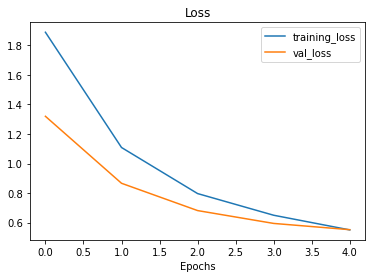

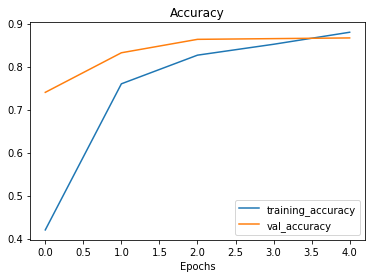

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through base_model of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}") 

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
# reduce the input_tensor to the mean of the values across the axes 1 and 2
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> 🛠 Practice: Try to do the same with the above two cells but this time use GlobalMaxPool2D... and see what happens.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of , for our own specifc problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentaton
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip 

unzip_data("10_food_classes_1_percent.zip")

--2023-01-27 12:24:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   217MB/s    in 0.6s    

2023-01-27 12:24:01 (217 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [ ]:
# we started with 750 , then we went to 75 , now we're at 7

In [ ]:
# Setup data loaders 
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model
To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:

* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
# It's a keras Sequential model
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having resclaing built-in
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

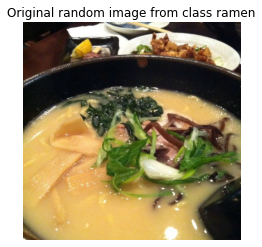

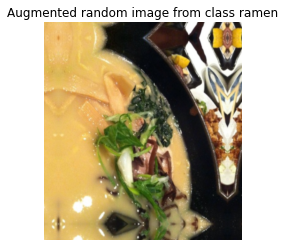

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0),training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False);

# print(augmented_img)
# Augmentation artificially increases the diversity of our training data

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)

# It has no top , because later we're gonna add our own top , which is the dense layer !!
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it.
x = base_model(x,training=False)

# The output that come out of above , remember , it's gonna be a large tensor .
# But we wanna condense that into a feature vector . We can do that using pooling

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                # Track model training logs
                                callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                         experiment_name="1_percent_data_aug")])



Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230127-122405
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.3992 - accuracy: 0.0857 - val_loss: 2.2251 - val_accuracy: 0.1859
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1710 - accuracy: 0.3143 - val_loss: 2.0831 - val_accuracy: 0.2730
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9160 - accuracy: 0.5000 - val_loss: 1.9576 - val_accuracy: 0.3997
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7722 - accuracy: 0.6286 - val_loss: 1.8581 - val_accuracy: 0.4474
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6275 - accuracy: 0.6286 - val_loss: 1.7447 - val_accuracy: 0.5164


In [ ]:
IMG_SIZE + (3,)

(224, 224, 3)

model_1 = keras.Model(inputs,outputs)

They want it to combine the inputs and get to the outputs. Does that make sense?
So we've got the model plus the inputs and let it know, hey, this is also the output you're looking for.
So it's going to stack all of these together in the way that it sees best fit.



In [ ]:
# Check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Only the paramters in the output layer are trainable

In [ ]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 1.7677 - accuracy: 0.5052


[1.7676769495010376, 0.5052000284194946]

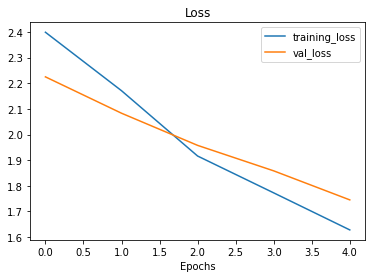

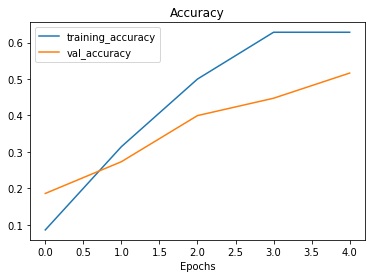

In [ ]:
# How do the model with 1% of the data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [ ]:
# Get 10% of data... (uncomment if you don't have it)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# How many images are in our directories ?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # if you're using a model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescaling built-in
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224,224,3)

# Create a frozen base model (also called as backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also ensures batchnorm layers don't get updated - https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weight/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",   # save every epoch
                                                         verbose=1)

### Fit model_2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230127-122441
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9730 - accuracy: 0.3587
Epoch 1: saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 18s 515ms/step - loss: 1.9730 - accuracy: 0.3587 - val_loss: 1.3946 - val_accuracy: 0.7138
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2892 - accuracy: 0.7267
Epoch 2: saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 11s 438ms/step - loss: 1.2892 - accuracy: 0.7267 - val_loss: 0.9725 - val_accuracy: 0.7977
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9838 - accuracy: 0.7853
Epoch 3: saving model to ten_percent_model_checkpoints_weight/checkpoint.ckpt
24/24 [==============================] - 9s 374ms/step - loss: 0.9838 - accuracy: 0.7853 - val_loss: 0.7764 - val_accuracy: 0.8306
Epoch

In [ ]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.5534 - accuracy: 0.8648


[0.5534375309944153, 0.864799976348877]

In [ ]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 0.6174 - accuracy: 0.8400


[0.6174060106277466, 0.8399999737739563]

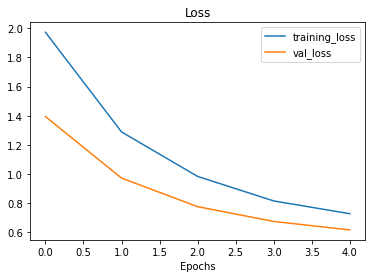

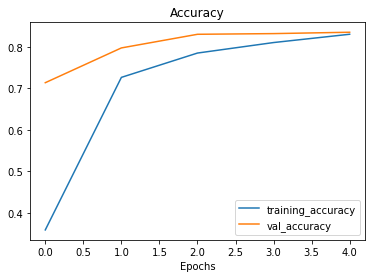

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [ ]:
# Load in saved model weights and evaluate model

# Any previously stored weights in model_2 should've been just over rided by the ones that are in the file (which are hopefully the same it earlier had , in this case)
model_2.load_weights(checkpoint_path) 

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6174 - accuracy: 0.8400


In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.6174060106277466, 0.8399999737739563]

In [ ]:
loaded_weights_model_results


[0.6174059510231018, 0.8399999737739563]

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))
     

array([ True,  True])

In [ ]:

# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data 

> 🔑 **Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable ?
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f3217f73a30> True
<keras.engine.sequential.Sequential object at 0x7f319b716b80> True
<keras.engine.functional.Functional object at 0x7f319b350400> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f319926c3d0> True
<keras.layers.core.dense.Dense object at 0x7f319b346ee0> True


In [ ]:
# What layers are in our base model (EfficientNetB0) and are they trainable ?
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
# How many trainable variables are in our base model ?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning , let's start by setting last 10 layers of our base_model.trainable = True
base_model.trainable=True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),  # when fine-tuning you typically want to lower the learning rate by 10x*
                metrics=["accuracy"]) 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values). A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
# Here we get all the weights from different layers .
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

This is a big tensor of numbers . these are the patterns that our EfficientNetB0 has learned on ImageNet . Now they're going to be updated !

In [ ]:
# Fine tune model_2 for another 5 epochs 

# (remember : that the model_2 that we have loaded in, is already trained for 5 epochs on a feature extraction model)
# because the Transfer Learning Workflow is you're first trying to feature extraction model to train that final output layer that you want to your own custom data, and then you go backwards and start
# fine tuning other layers .


fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],  # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer learning",
                                                                                     experiment_name="10_percent_fine_tune_last_10")])
               

Saving TensorBoard log files to: transfer learning/10_percent_fine_tune_last_10/20230127-122607
Epoch 5/10
24/24 [==============================] - 20s 520ms/step - loss: 0.6285 - accuracy: 0.8400 - val_loss: 0.4807 - val_accuracy: 0.8487
Epoch 6/10
24/24 [==============================] - 10s 385ms/step - loss: 0.5088 - accuracy: 0.8560 - val_loss: 0.4262 - val_accuracy: 0.8553
Epoch 7/10
24/24 [==============================] - 8s 335ms/step - loss: 0.4434 - accuracy: 0.8667 - val_loss: 0.4178 - val_accuracy: 0.8553
Epoch 8/10
24/24 [==============================] - 8s 304ms/step - loss: 0.3910 - accuracy: 0.8840 - val_loss: 0.3962 - val_accuracy: 0.8684
Epoch 9/10
24/24 [==============================] - 8s 330ms/step - loss: 0.3308 - accuracy: 0.9040 - val_loss: 0.3890 - val_accuracy: 0.8635
Epoch 10/10
24/24 [==============================] - 9s 367ms/step - loss: 0.3260 - accuracy: 0.9120 - val_loss: 0.4193 - val_accuracy: 0.8569


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.4119 - accuracy: 0.8580


In [ ]:
results_10_percent_data_aug

[0.6174060106277466, 0.8399999737739563]

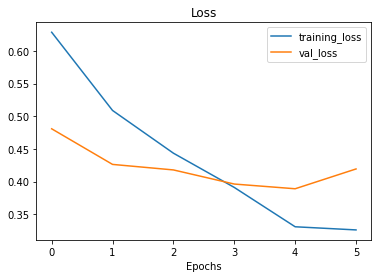

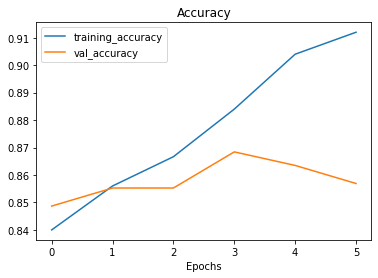

In [ ]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)


The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running fit() with another (e.g. before and after fine-tuning).

In [ ]:
# Let's create a function to compare histories
def compare_historys(original_history,new_history,initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original_history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  # 2 rows , 1 col , 1st part
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Traning Accuracy")
  plt.plot(total_val_acc,label="Val Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.title("Training and Validation Accuracy")
  plt.legend(loc="lower right")

  # Make plot for loss
  plt.figure(figsize=(8,8))
  # 2 rows , 1 col , 2nd part
  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Traning Loss")
  plt.plot(total_val_loss,label="Val Loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.title("Training and Validation Loss")
  plt.legend(loc="upper right")

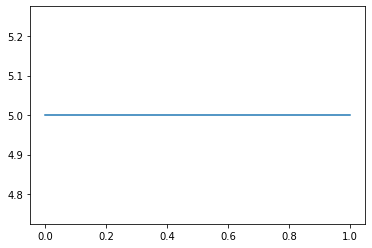

In [ ]:
# Just for logic clearing of above
# example
plt.plot([5,5])

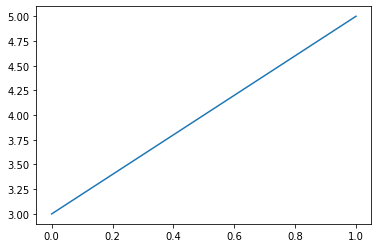

In [ ]:
plt.plot([3,5])

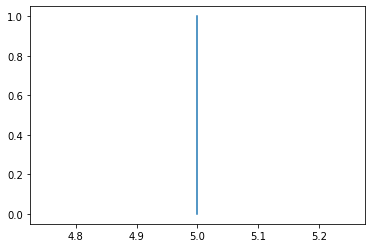

In [ ]:
plt.plot([5,5], plt.ylim())

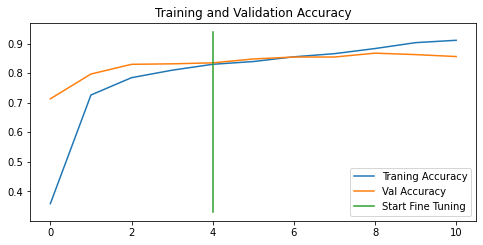

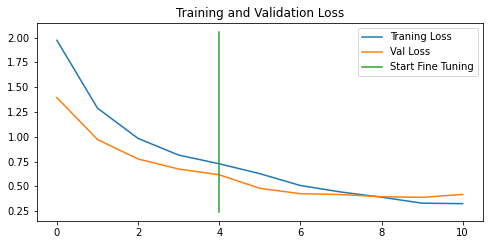

In [ ]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-01-27 12:27:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.128, 64.233.182.128, 64.233.183.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   245MB/s    in 2.0s    

2023-01-27 12:27:21 (245 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with ?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 image_size=IMG_SIZE,
                                                                                 label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


this is just going to go through our respective directories and pull out the images.

So within train it's going to go OK.

All the images in the chicken curry folder have the label chicken curry.

All of the images in the chicken wings folder have the label chicken wings.

The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [ ]:
# Evaluate model_2 (this is the fine-tuned on 10 % of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.4119 - accuracy: 0.8580


[0.41190361976623535, 0.8579999804496765]

In [ ]:
results_fine_tune_10_percent

[0.41190361976623535, 0.8579999804496765]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Load weights from checkpoint , that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from

model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.6174 - accuracy: 0.8400


[0.617405891418457, 0.8399999737739563]

In [ ]:
# Check to see if our model_2 has been reverted back to the feature extraction
results_10_percent_data_aug

[0.6174060106277466, 0.8399999737739563]

Alright  , the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data_augmentation(model_2) and we saved the model's weights using "ModelCheckpoint" callback
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base_model unfrozen()
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data(model_4) 


In [ ]:
# Check which layers are tunable in the whole model
for layer_number , layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)
  


0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable 
for layer_number , layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
# as we made changes to our model , so we now need to recompile it

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# In transfer learning , the order is : feature extraction first , then fine tuning

In [ ]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230127-141740
Epoch 5/10
235/235 [==============================] - 69s 256ms/step - loss: 0.6512 - accuracy: 0.7940 - val_loss: 0.4067 - val_accuracy: 0.8602
Epoch 6/10
235/235 [==============================] - 55s 230ms/step - loss: 0.5233 - accuracy: 0.8349 - val_loss: 0.3745 - val_accuracy: 0.8799
Epoch 7/10
235/235 [==============================] - 55s 233ms/step - loss: 0.4698 - accuracy: 0.8483 - val_loss: 0.3597 - val_accuracy: 0.8849
Epoch 8/10
235/235 [==============================] - 53s 224ms/step - loss: 0.4215 - accuracy: 0.8635 - val_loss: 0.3499 - val_accuracy: 0.8750
Epoch 9/10
235/235 [==============================] - 50s 208ms/step - loss: 0.3954 - accuracy: 0.8719 - val_loss: 0.3495 - val_accuracy: 0.8766
Epoch 10/10
235/235 [==============================] - 44s 185ms/step - loss: 0.3528 - accuracy: 0.8861 - val_loss: 0.3383 - val_accuracy: 0.8849


In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 70ms/step - loss: 0.2749 - accuracy: 0.9076


[0.2749124765396118, 0.9075999855995178]

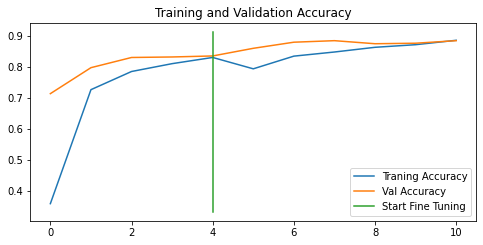

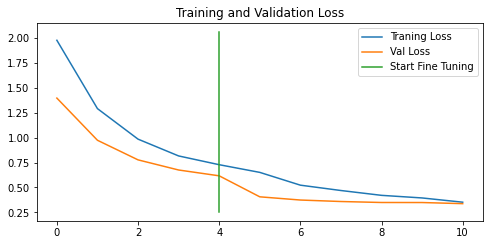

In [ ]:
# How did fine-tuning go with more data ??
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

> 🔑 Note: Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading

My TensorBoard experiments are available at: https://tensorboard.dev/experiment/C3bz7kBDRC2UozT6fbrKBQ/

Now deleting the output of the previous cell (as it contains my secret code

In [ ]:
# # View all of your uploaded TensorBoard.dev experiments (public)
!tensorboard dev list

https://tensorboard.dev/experiment/C3bz7kBDRC2UozT6fbrKBQ/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   C3bz7kBDRC2UozT6fbrKBQ
	Created              2023-01-27 14:35:30 (10 minutes ago)
	Updated              2023-01-27 14:35:33 (10 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              126
	Tensor bytes         0
	Binary object bytes  3464151
Total: 1 experiment(s)


In [ ]:
# # To delete an experiment
# !tensorboard dev delete --experiment_id C3bz7kBDRC2UozT6fbrKBQ           # Change this for the experiment ID you want to delete